### Lab 02: A little bit lower API


In [ ]:
#import thư viện cần thiết
import tensorflow as tf
from tensorflow import keras
import numpy as np

## thư viện để vẽ đồ thị
import matplotlib.pyplot as plt

In [ ]:
## tải MNIST dataset từ keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

#Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

### 1. Hãy tạo một class DoubleFullyConnectedLayer với hàm activation lớp fully connected đầu là relu và lớp fully connected tiếp theo là softmax

**Layer**



In [ ]:
from keras import backend as K
from keras.models import Model
import tensorflow as tf
from keras.layers import Input, Layer

class DoubleFullyConnectedLayer(Layer):
    def __init__(self, n_units=10, activation_1 = tf.nn.relu, activation_2 = tf.nn.softmax):
        print("__init__ called")
        
        # gọi hàm khởi tạo của lớp cha
        super(DoubleFullyConnectedLayer, self).__init__()
        # lưu lại số nơ-ron của lớp này
        self.n_units = n_units
        self.activation_function_1 = activation_1
        self.activation_function_2 = activation_2

(1, 980) x (980, x)  -> (1, x)    -> (980 +1) * x
(1, x) x (x, 10) -> (1, 10) -> (x+1) * 10 

 ((x * 1)+1*x) + (10*x + 10) = 

dài x rộng 

    def build(self, input_shape):
        print("build called")
        self.kernel_1 = self.add_weight(name='kernel_1',
                                        shape=[int(input_shape[-1]), self.n_units*5], 
                                        initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))
        self.kernel_2 = self.add_weight(name='kernel_2',
                                        shape=[self.kernel_1.shape[-1], self.n_units], 
                                        initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))
        
        ## Tương tự, khai báo một vector bias
        self.bias_1 = self.add_weight(name='bias_1',
                                      shape=[self.n_units*5],
                                      initializer=keras.initializers.Ones())
        self.bias_2 = self.add_weight(name='bias_2',
                                      shape=[self.n_units],
                                      initializer=keras.initializers.Ones())

        
    def call(self, inputs):

        ## input chính là một lớp keras (hoặc tensor) truyền vào layer này
        ## tham số input là bắt buộc
        
        ## Công thức toán học của lớp này
        ## tensorflow có hỗ broadcasting nên self.bias sẽ được cộng vào từng dòng của ma trận
        matmul_1 = tf.matmul(inputs, self.kernel_1) + self.bias_1
        activate_1 = self.activation_function_1(matmul_1)  ##áp dụng hàm kích hoạt

        matmul_2 = tf.matmul(activate_1, self.kernel_2) + self.bias_2
        outputs = self.activation_function_2(matmul_2)  ##áp dụng hàm kích hoạt
        
        return outputs

In [ ]:
class ConvMaxpoolBlock(keras.layers.Layer):
    ## Lớp này sẽ xây dựng lớp convolutional layer và maxpooling
    
    def __init__(self, filter_size, n_filters):
        super(ConvMaxpoolBlock, self).__init__()
        # lưu lại mấy thông số
        self.filter_size = filter_size
        self.n_filters = n_filters
        
    def build(self, input_shape):
        ## ta giả sử input là một tensor (layer) có kích thước [None, height, weight, n_channels]
        
        ## khởi tạo và khai báo kernel
        self.kernel = self.add_weight(name='kernel_3',
                                        shape=[self.filter_size[0], self.filter_size[1], int(input_shape[-1]), self.n_filters],
                                        initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
        
        ## khởi tạo và khai báo bias
        self.bias = self.add_weight(name='bias_3',
                                      shape=[self.n_filters],
                                        initializer=keras.initializers.Ones())
        
    def call(self, inputs):
        ## phép toán tích chập
        conv = K.conv2d(x=inputs,
                            kernel=self.kernel,
                       padding='same')
        ## cộng bias (có broadcasting hỗ trợ nên lập trình đơn giản)
        conv = conv + self.bias
        ## áp dụng hàm kích hoạt
        conv = tf.nn.relu(conv)
        ## áp dụng maxpooling
        maxpool = K.pool2d(conv, 
                           pool_size=(2,2), 
                           strides=(2,2),
                          pool_mode='max')
                          
        return maxpool

### 2. Hãy huấn luyện một neural-network theo cấu trúc saug:

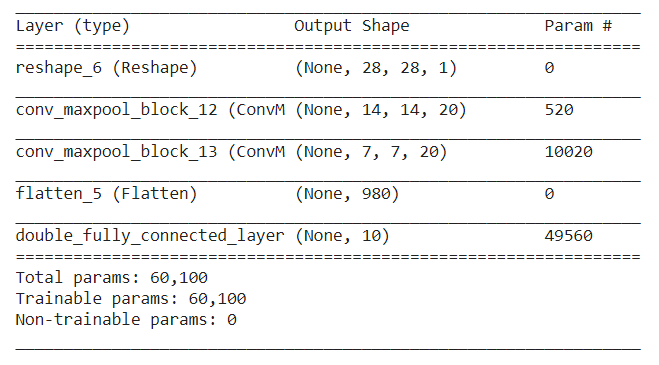

In [ ]:
## Tạo layer input
inputs = keras.layers.Input(shape=(28,28))

## Reshape input
inputs_reshape = keras.layers.Reshape((28,28,1))(inputs)

## Model

conv = ConvMaxpoolBlock((5,5),20) (inputs_reshape)

conv2 = ConvMaxpoolBlock((5,5),20) (conv)

flatten = keras.layers.Flatten()(conv2)

dense = DoubleFullyConnectedLayer(n_units = 10) (flatten)

model = keras.models.Model(inputs=inputs, outputs=dense)

## Compile model, 
model.compile(optimizer='adam',
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=["accuracy"])
    

## In toàn bộ cấu trúc của model
print("Cấu trúc của model: ")
model.summary()

__init__ called
build called
(980, 50)
(50, 10)
Cấu trúc của model: 
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_maxpool_block (ConvMaxp (None, 14, 14, 20)        520       
_________________________________________________________________
conv_maxpool_block_1 (ConvMa (None, 7, 7, 20)          10020     
_________________________________________________________________
flatten (Flatten)            (None, 980)               0         
_________________________________________________________________
double_fully_connected_layer (None, 10)                49560     
Total params: 60,100
Trainable params: 60,100
Non-t

**Training**

In [ ]:
from keras.callbacks import History 
history = History()

model.fit(X_train,y_train,
                  epochs=10,
                  batch_size=100,
                  validation_data=(X_valid,y_valid), callbacks=[history])

## Lưu model thành một file
model.save_weights("second_model.h5")

## Load model
model.load_weights("second_model.h5")

Epoch 1/10
540/540 [==============================] - 2s 3ms/step - loss: 0.7965 - accuracy: 0.7309 - val_loss: 0.2430 - val_accuracy: 0.9245
Epoch 2/10
540/540 [==============================] - 2s 3ms/step - loss: 0.1724 - accuracy: 0.9471 - val_loss: 0.1380 - val_accuracy: 0.9562
Epoch 3/10
540/540 [==============================] - 2s 3ms/step - loss: 0.1124 - accuracy: 0.9650 - val_loss: 0.1080 - val_accuracy: 0.9648
Epoch 4/10
540/540 [==============================] - 2s 3ms/step - loss: 0.0906 - accuracy: 0.9713 - val_loss: 0.0900 - val_accuracy: 0.9712
Epoch 5/10
540/540 [==============================] - 2s 3ms/step - loss: 0.0815 - accuracy: 0.9742 - val_loss: 0.0764 - val_accuracy: 0.9772
Epoch 6/10
540/540 [==============================] - 2s 3ms/step - loss: 0.0697 - accuracy: 0.9780 - val_loss: 0.0783 - val_accuracy: 0.9753
Epoch 7/10
540/540 [==============================] - 2s 3ms/step - loss: 0.0628 - accuracy: 0.9806 - val_loss: 0.0735 - val_accuracy: 0.9765
Epoch 

3.Sau khi huấn luyện hãy vẽ biểu đồ accuracy từng epoch trên tập training và tập validation. Có thể vẽ như hình sau:

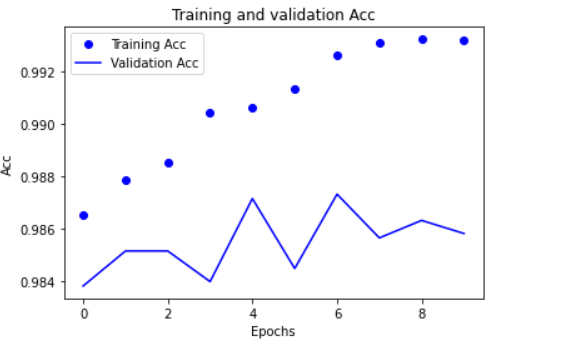

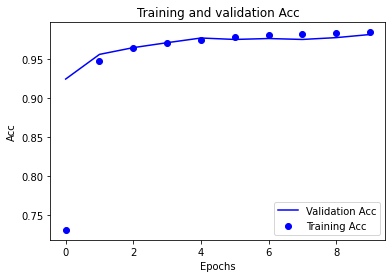

In [ ]:
### Vẽ sơ đồ

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epoch = [i for i in range(len(train_acc))]

plt.scatter(epoch, train_acc, c = 'blue', label = 'Training Acc')
plt.plot(epoch, val_acc, c = 'blue', label = 'Validation Acc')

plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title('Training and validation Acc')
plt.legend()

plt.show()